Searching for images in: 'train_processed'
Found 889366 total images. Selecting 4 to display.


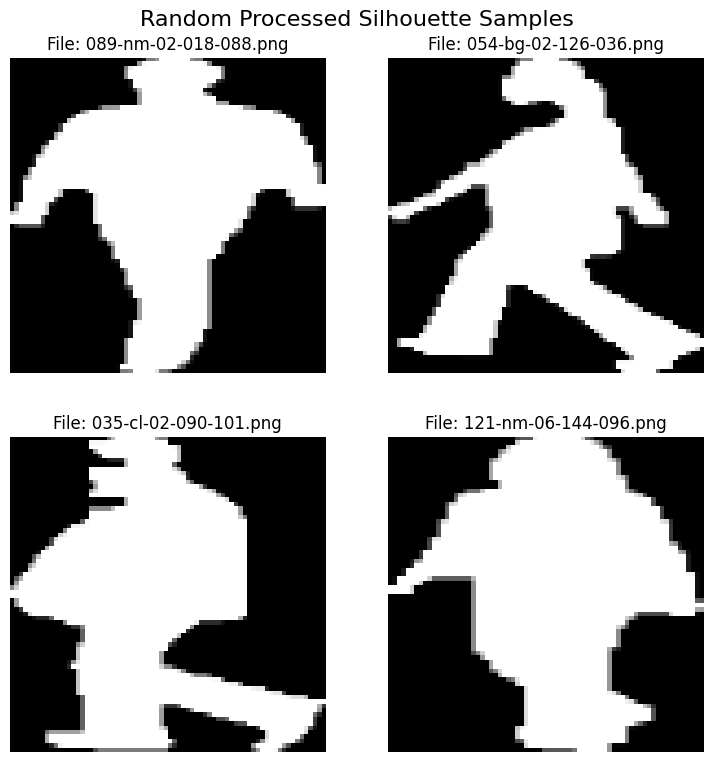

In [4]:
import os
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Path to the directory containing your PROCESSED images.
PROCESSED_DATA_DIR = 'train_processed' 

# 2. Number of images to display at once. 4 will create a 2x2 grid.
NUM_IMAGES_TO_SHOW = 4


def visualize_processed_data():
    """
    Selects random processed images, parses their filenames, and displays them
    with descriptive titles in a grid.
    """
    print(f"Searching for images in: '{PROCESSED_DATA_DIR}'")

    # Check if the directory exists
    if not os.path.isdir(PROCESSED_DATA_DIR):
        print(f"Error: Directory not found at '{PROCESSED_DATA_DIR}'.")
        print("Please make sure you have run the preprocessing script and the")
        print(" 'train_processed' and/or 'validation_processed' folders exist.")
        return

    # Find all .png image files recursively in the directory
    all_image_paths = glob.glob(os.path.join(PROCESSED_DATA_DIR, '**', '*.png'), recursive=True)

    if not all_image_paths:
        print(f"Error: No images found in '{PROCESSED_DATA_DIR}'.")
        return
    
    print(f"Found {len(all_image_paths)} total images. Selecting {NUM_IMAGES_TO_SHOW} to display.")

    # Randomly select a sample of images
    selected_paths = random.sample(all_image_paths, min(NUM_IMAGES_TO_SHOW, len(all_image_paths)))

    # Create a plot to display the images. We'll make a 2x2 grid for 4 images.
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, img_path in enumerate(selected_paths):
        # 1. Read the image
        img = mpimg.imread(img_path)
        
        # 2. Parse the filename to get details. E.g., '001-nm-01-090.png'
        filename = os.path.basename(img_path)
        parts = filename.replace('.png', '').split('-')
        
        title = f"File: {filename}" # Default title
        if len(parts) == 4:
            subject_id, condition, sequence, angle = parts
            title = f"Subject: {subject_id}\nType: {condition}-{sequence}, Angle: {angle}"
        
        # 3. Display the image on its subplot
        ax = axes[i]
        ax.imshow(img, cmap='gray') # Use a grayscale colormap
        ax.set_title(title)
        ax.axis('off') # Hide the x and y axis ticks for a cleaner look

    # Hide any unused subplots if NUM_IMAGES_TO_SHOW is less than 4
    for j in range(len(selected_paths), len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    fig.suptitle('Random Processed Silhouette Samples', fontsize=16)
    plt.show()

if __name__ == '__main__':
    visualize_processed_data()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import time
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# --- Configuration ---
DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123

# --- Model & Training Parameters ---
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# --- NEW: Definition of a Simple CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 3 x 72 x 72
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 16 x 36 x 36

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 32 x 18 x 18

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: 64 x 9 x 9
        )
        # Fully connected layers (classifier)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 9, 512), # 64 channels * 9x9 image size
            nn.ReLU(),
            nn.Linear(512, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def train_gait_model():
    """
    Main function to set up the dataset, build the model, and run the training loop.
    MODIFIED: Now returns training history for plotting.
    """
    print(f"Initializing OPTIMIZED training process for {NUM_CLASSES} subjects...")

    # --- YOUR ORIGINAL CODE (unchanged until training loop) ---
    # [All data loading, transforms, model setup code remains EXACTLY the same]
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'validation': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    train_dir = os.path.join(DATA_DIR, 'train_processed')
    validation_dir = os.path.join(DATA_DIR, 'validation_processed')
    
    full_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
    }
    
    if NUM_SUBJECTS_TO_TRAIN is not None:
        all_classes = sorted(full_datasets['train'].classes)
        subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
        class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
        
        for phase in ['train', 'validation']:
            full_dataset = full_datasets[phase]
            new_samples = []
            for path, old_idx in full_dataset.samples:
                class_name = all_classes[old_idx]
                if class_name in class_to_idx_subset:
                     new_samples.append((path, class_to_idx_subset[class_name]))
            
            full_datasets[phase].samples = new_samples
            full_datasets[phase].classes = subset_classes
            full_datasets[phase].class_to_idx = class_to_idx_subset
            full_datasets[phase].targets = [s[1] for s in new_samples]

    dataloaders = {
        'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
        'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    }

    dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
    print(f"Training data size: {dataset_sizes['train']}")
    print(f"Validation data size: {dataset_sizes['validation']}")

    model = SimpleCNN(num_classes=NUM_CLASSES)
    print("Using SimpleCNN model for this training run.")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training will use device: {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scaler = GradScaler()
    use_amp = torch.cuda.is_available()

    # --- NEW: Lists to store metrics for plotting ---
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()
    print("\nStarting model training...")

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
            
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with autocast(enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # --- NEW: Store metrics ---
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    torch.save(model.state_dict(), 'gait_simple_cnn_weights.pth')
    torch.save(model, 'gait_simple_cnn_entire_model.pth')
    print("Model successfully saved")

    
    # --- NEW: Return metrics for plotting ---
    return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']

    

In [6]:
# Cell 1 - This CALLS the function and stores results
model, train_losses, val_losses, train_accs, val_accs, val_dataset = train_gait_model()
print("Training completed! Metrics collected for plotting.")


Initializing OPTIMIZED training process for 123 subjects...
Training data size: 889366
Validation data size: 222404
Using SimpleCNN model for this training run.
Training will use device: cuda:0


C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\3706345982.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting model training...
Epoch 1/10
----------


Train Phase:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\3706345982.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train Phase: 100%|██████████| 27793/27793 [05:46<00:00, 80.18it/s] 


Train Loss: 0.9125 Acc: 0.7499


Validation Phase: 100%|██████████| 6951/6951 [01:22<00:00, 84.05it/s] 


Validation Loss: 0.4961 Acc: 0.8563
Epoch 2/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:02<00:00, 91.85it/s] 


Train Loss: 0.4199 Acc: 0.8768


Validation Phase: 100%|██████████| 6951/6951 [01:24<00:00, 82.16it/s] 


Validation Loss: 0.4269 Acc: 0.8749
Epoch 3/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:06<00:00, 90.78it/s] 


Train Loss: 0.3289 Acc: 0.9017


Validation Phase: 100%|██████████| 6951/6951 [01:22<00:00, 84.02it/s] 


Validation Loss: 0.3504 Acc: 0.8975
Epoch 4/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:07<00:00, 90.36it/s] 


Train Loss: 0.2795 Acc: 0.9155


Validation Phase: 100%|██████████| 6951/6951 [01:23<00:00, 83.19it/s] 


Validation Loss: 0.3501 Acc: 0.8997
Epoch 5/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:04<00:00, 91.19it/s] 


Train Loss: 0.2500 Acc: 0.9242


Validation Phase: 100%|██████████| 6951/6951 [01:22<00:00, 84.52it/s] 


Validation Loss: 0.3220 Acc: 0.9064
Epoch 6/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:05<00:00, 91.08it/s] 


Train Loss: 0.2255 Acc: 0.9314


Validation Phase: 100%|██████████| 6951/6951 [01:20<00:00, 85.86it/s] 


Validation Loss: 0.3053 Acc: 0.9144
Epoch 7/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:04<00:00, 91.31it/s] 


Train Loss: 0.2096 Acc: 0.9354


Validation Phase: 100%|██████████| 6951/6951 [01:22<00:00, 83.92it/s] 


Validation Loss: 0.2945 Acc: 0.9169
Epoch 8/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:11<00:00, 89.25it/s] 


Train Loss: 0.1944 Acc: 0.9401


Validation Phase: 100%|██████████| 6951/6951 [01:14<00:00, 93.15it/s] 


Validation Loss: 0.3047 Acc: 0.9163
Epoch 9/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:55<00:00, 94.18it/s] 


Train Loss: 0.1834 Acc: 0.9433


Validation Phase: 100%|██████████| 6951/6951 [01:06<00:00, 104.27it/s]


Validation Loss: 0.2866 Acc: 0.9213
Epoch 10/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:35<00:00, 101.01it/s]


Train Loss: 0.1740 Acc: 0.9460


Validation Phase: 100%|██████████| 6951/6951 [01:06<00:00, 104.23it/s]


Validation Loss: 0.2969 Acc: 0.9238

Training complete in 64m 7s
Model successfully saved
Training completed! Metrics collected for plotting.


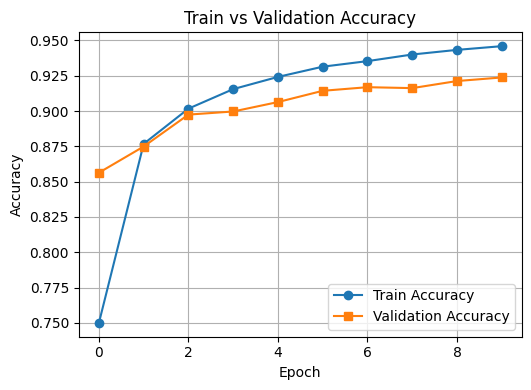

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='s')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


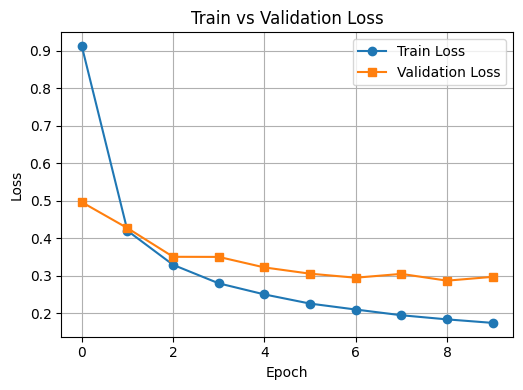

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on validation set
device = next(model.parameters()).device
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix shape: {cm.shape}")


Confusion Matrix shape: (123, 123)


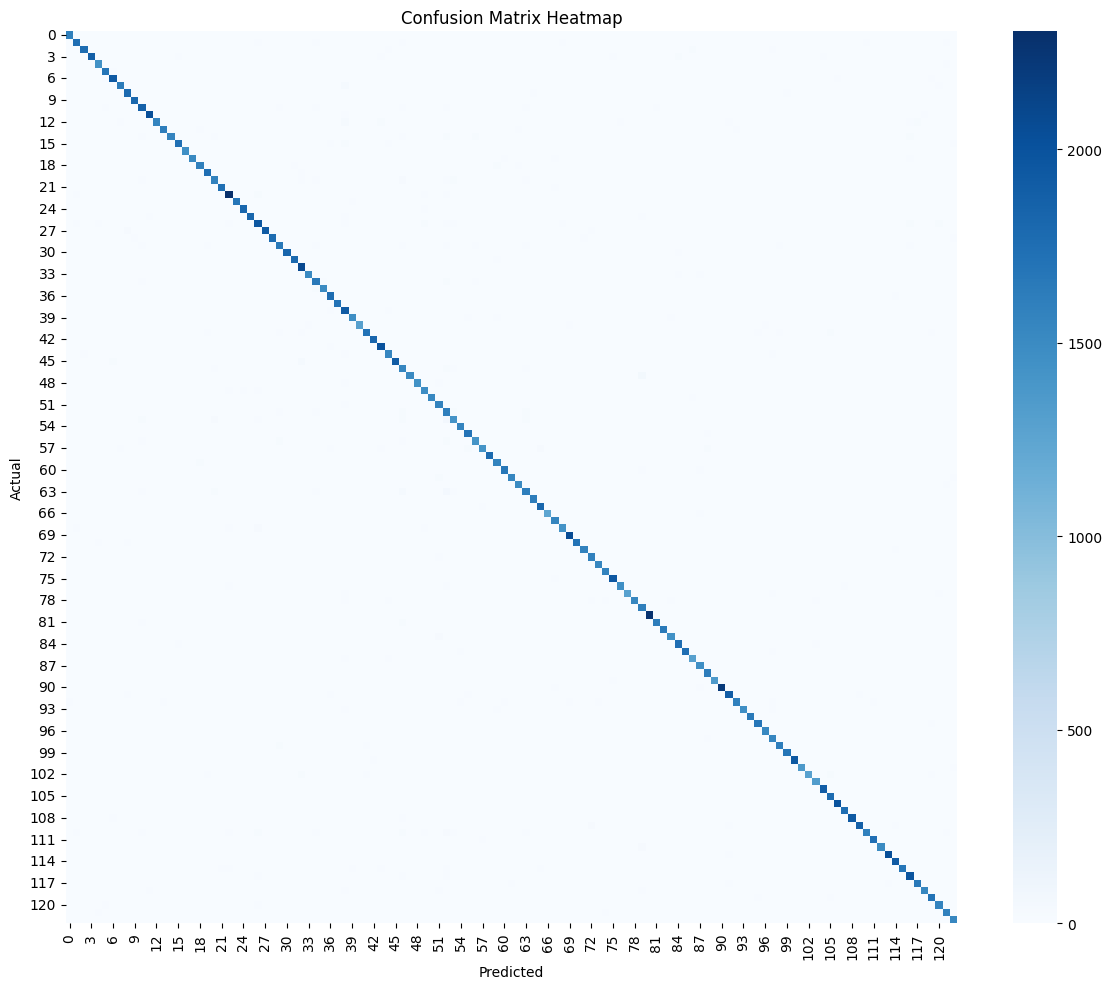

Classes shown (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [10]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show class names (first 10 for readability if too many classes)
class_names = val_dataset.classes[:min(10, len(val_dataset.classes))]
print("Classes shown (first 10):", class_names)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
import sys
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123 
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

class XceptionTrainer:
    def train_gait_model(self):
        """
        Main function to set up the dataset, build the model, and run the training loop.
        MODIFIED: Now returns training history for plotting.
        """
        print(f"Initializing OPTIMIZED Xception training for {NUM_CLASSES} subjects...")

        # --- YOUR ORIGINAL CODE (unchanged until training loop) ---
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
            'validation': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
        }

        train_dir = os.path.join(DATA_DIR, 'train_processed')
        validation_dir = os.path.join(DATA_DIR, 'validation_processed')

        print(f"Loading data from source directories...")
        
        full_datasets = {
            'train': datasets.ImageFolder(train_dir, data_transforms['train']),
            'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
        }
        
        if NUM_SUBJECTS_TO_TRAIN is not None:
            print(f"Filtering dataset to the first {NUM_SUBJECTS_TO_TRAIN} subjects...")
            
            all_classes = sorted(full_datasets['train'].classes)
            subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
            
            class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
            
            for phase in ['train', 'validation']:
                full_dataset = full_datasets[phase]
                new_samples = []
                for path, old_idx in full_dataset.samples:
                    class_name = all_classes[old_idx]
                    if class_name in class_to_idx_subset:
                         new_samples.append((path, class_to_idx_subset[class_name]))
                
                full_datasets[phase].samples = new_samples
                full_datasets[phase].classes = subset_classes
                full_datasets[phase].class_to_idx = class_to_idx_subset
                full_datasets[phase].targets = [s[1] for s in new_samples]

        dataloaders = {
            'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
            'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
        }

        dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
        print(f"Training data size: {dataset_sizes['train']}")
        print(f"Validation data size: {dataset_sizes['validation']}")

        # Xception model
        model_Xception = timm.create_model('xception', pretrained=True, num_classes=NUM_CLASSES)
        print("Xception model loaded via TIMM.")
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training will use device: {device}")
        model = model_Xception.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        scaler = GradScaler()
        use_amp = torch.cuda.is_available()

        # --- NEW: Lists to store metrics ---
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        start_time = time.time()
        print("\nStarting Xception training...")

        for epoch in range(NUM_EPOCHS):
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
            print('-' * 10)

            for phase in ['train', 'validation']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
                
                for inputs, labels in progress_bar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad(set_to_none=True)

                    with autocast(enabled=use_amp):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # --- NEW: Store metrics ---
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.cpu().item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.cpu().item())

        time_elapsed = time.time() - start_time
        print(f"\nXception Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        
        torch.save(model_Xception.state_dict(), 'gait_Xception_weights.pth')
        torch.save(model, 'gait_Xception_entire_model.pth')
        print("Model successfully saved")
        
        # --- NEW: Return metrics ---
        return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']

# Run training
if __name__ == '__main__':
    trainer = XceptionTrainer()
    model, train_losses, val_losses, train_accs, val_accs, val_dataset = trainer.train_gait_model()
    print("Xception Training completed! Metrics ready for plotting.")


Initializing OPTIMIZED Xception training for 123 subjects...
Loading data from source directories...
Filtering dataset to the first 123 subjects...
Training data size: 889366
Validation data size: 222404


C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\3793940986.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Xception model loaded via TIMM.
Training will use device: cuda:0

Starting Xception training...
Epoch 1/10
----------


Train Phase:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\3793940986.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train Phase: 100%|██████████| 27793/27793 [35:57<00:00, 12.88it/s]


Train Loss: 0.8578 Acc: 0.7644


Validation Phase: 100%|██████████| 6951/6951 [03:06<00:00, 37.36it/s]


Validation Loss: 0.2004 Acc: 0.9384
Epoch 2/10
----------


Train Phase: 100%|██████████| 27793/27793 [32:32<00:00, 14.24it/s]


Train Loss: 0.1803 Acc: 0.9443


Validation Phase: 100%|██████████| 6951/6951 [03:09<00:00, 36.60it/s]


Validation Loss: 0.1199 Acc: 0.9624
Epoch 3/10
----------


Train Phase: 100%|██████████| 27793/27793 [31:26<00:00, 14.73it/s]


Train Loss: 0.1080 Acc: 0.9661


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.53it/s]


Validation Loss: 0.0875 Acc: 0.9733
Epoch 4/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:09<00:00, 15.36it/s]


Train Loss: 0.0765 Acc: 0.9758


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.51it/s]


Validation Loss: 0.0695 Acc: 0.9789
Epoch 5/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:06<00:00, 15.39it/s]


Train Loss: 0.0587 Acc: 0.9810


Validation Phase: 100%|██████████| 6951/6951 [03:10<00:00, 36.52it/s]


Validation Loss: 0.0604 Acc: 0.9820
Epoch 6/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:09<00:00, 15.36it/s]


Train Loss: 0.0474 Acc: 0.9845


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.63it/s]


Validation Loss: 0.0581 Acc: 0.9827
Epoch 7/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:04<00:00, 15.40it/s]


Train Loss: 0.0398 Acc: 0.9872


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.55it/s]


Validation Loss: 0.0508 Acc: 0.9848
Epoch 8/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:22<00:00, 15.25it/s]


Train Loss: 0.0344 Acc: 0.9888


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.70it/s]


Validation Loss: 0.0589 Acc: 0.9836
Epoch 9/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:16<00:00, 15.30it/s]


Train Loss: 0.0303 Acc: 0.9903


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.72it/s]


Validation Loss: 0.0544 Acc: 0.9847
Epoch 10/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:25<00:00, 15.22it/s] 


Train Loss: 0.0270 Acc: 0.9913


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.70it/s]


Validation Loss: 0.0472 Acc: 0.9868

Xception Training complete in 342m 31s
Xception Training completed! Metrics ready for plotting.


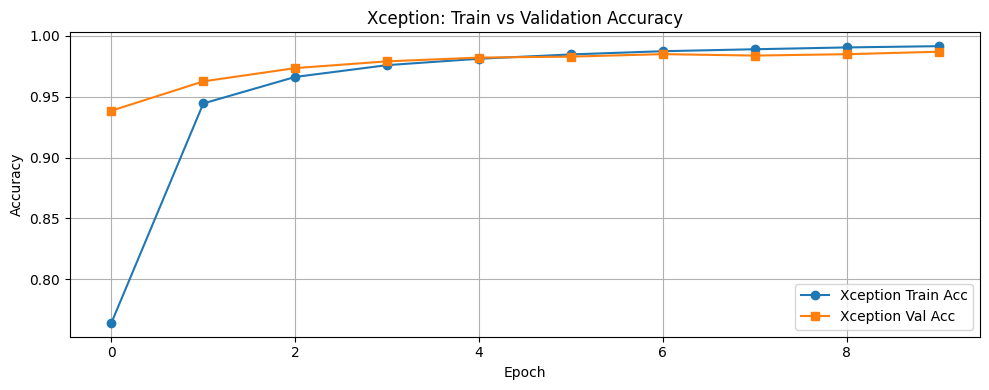

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Xception Train Acc', marker='o')
plt.plot(val_accs, label='Xception Val Acc', marker='s')
plt.title('Xception: Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


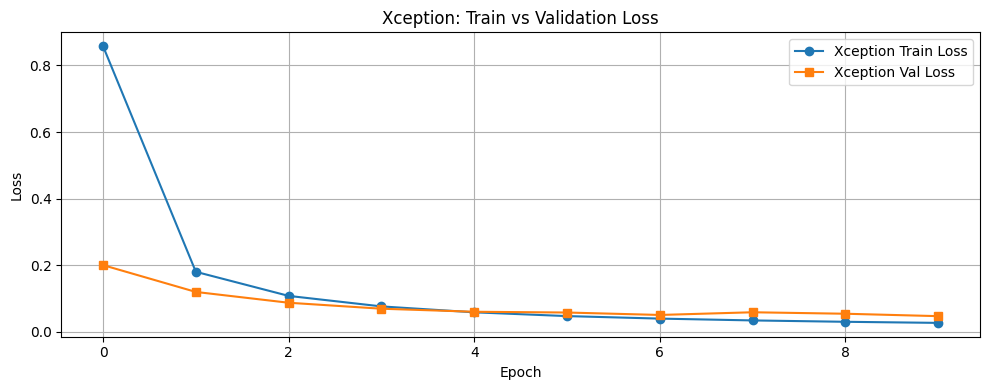

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Xception Train Loss', marker='o')
plt.plot(val_losses, label='Xception Val Loss', marker='s')
plt.title('Xception: Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
device = next(model.parameters()).device
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(f"Xception Confusion Matrix shape: {cm.shape}")


Xception Confusion Matrix shape: (123, 123)


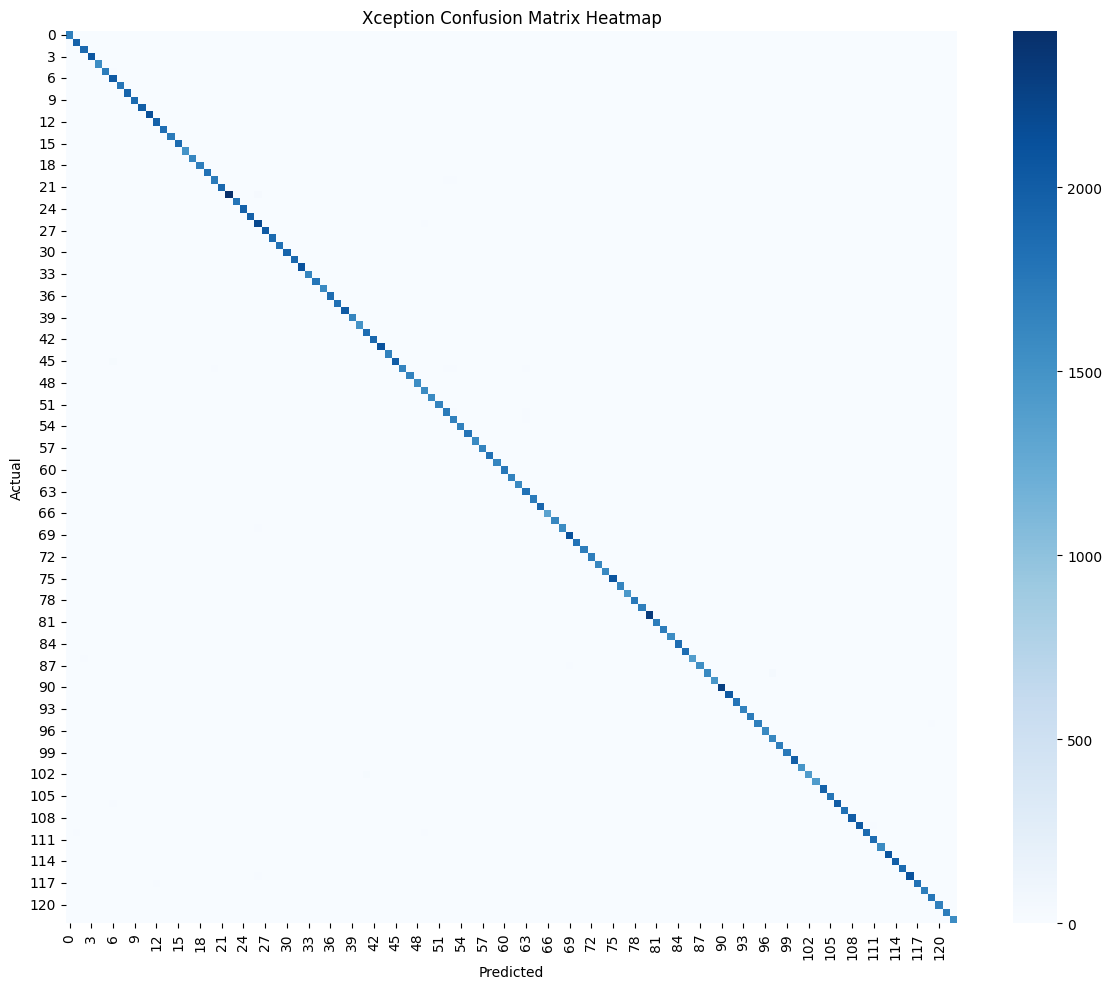

Xception Classes (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Xception Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

class_names = val_dataset.classes[:min(10, len(val_dataset.classes))]
print("Xception Classes (first 10):", class_names)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123 
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

class ResNetTrainer:
    def train_gait_model(self):
        """
        ResNet model training with metric collection for plotting.
        """
        print(f"Initializing ResNet training for {NUM_CLASSES} subjects...")

        # Data transforms (same as before)
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
            'validation': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
        }

        train_dir = os.path.join(DATA_DIR, 'train_processed')
        validation_dir = os.path.join(DATA_DIR, 'validation_processed')

        full_datasets = {
            'train': datasets.ImageFolder(train_dir, data_transforms['train']),
            'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
        }
        
        # Filter to subset of subjects
        if NUM_SUBJECTS_TO_TRAIN is not None:
            all_classes = sorted(full_datasets['train'].classes)
            subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
            class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
            
            for phase in ['train', 'validation']:
                full_dataset = full_datasets[phase]
                new_samples = []
                for path, old_idx in full_dataset.samples:
                    class_name = all_classes[old_idx]
                    if class_name in class_to_idx_subset:
                        new_samples.append((path, class_to_idx_subset[class_name]))
                
                full_datasets[phase].samples = new_samples
                full_datasets[phase].classes = subset_classes
                full_datasets[phase].class_to_idx = class_to_idx_subset
                full_datasets[phase].targets = [s[1] for s in new_samples]

        dataloaders = {
            'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
            'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
        }

        dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
        print(f"Training data size: {dataset_sizes['train']}")
        print(f"Validation data size: {dataset_sizes['validation']}")

        # --- RESNET MODEL via TIMM ---
        model_ResNet = timm.create_model('resnet50', pretrained=True, num_classes=NUM_CLASSES)
        print("ResNet50 model loaded via TIMM.")
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training on: {device}")
        model = model_ResNet.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scaler = GradScaler()
        use_amp = torch.cuda.is_available()

        # Metric storage
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        start_time = time.time()
        print("\nStarting ResNet50 training...")

        for epoch in range(NUM_EPOCHS):
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
            print('-' * 10)

            for phase in ['train', 'validation']:
                model.train() if phase == 'train' else model.eval()

                running_loss = 0.0
                running_corrects = 0

                progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()}')
                
                for inputs, labels in progress_bar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad(set_to_none=True)

                    with autocast(enabled=use_amp):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.cpu().item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.cpu().item())

        time_elapsed = time.time() - start_time
        print(f"\nResNet50 Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        
        torch.save(model_ResNet.state_dict(), 'gait_ResNet50_weights.pth')
        torch.save(model, 'gait_ResNet50_entire_model.pth')
        print("Model successfully saved")
        
        return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']

# EXECUTE TRAINING
trainer = ResNetTrainer()
model, train_losses, val_losses, train_accs, val_accs, val_dataset = trainer.train_gait_model()
print(" ResNet50 Training done! Ready for plots.")


d:\Study\Coding\Project\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
d:\Study\Coding\Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing ResNet training for 123 subjects...
Training data size: 889366
Validation data size: 222404


C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\4154039475.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


ResNet50 model loaded via TIMM.
Training on: cuda:0

Starting ResNet50 training...
Epoch 1/10
----------


Train:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\4154039475.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train: 100%|██████████| 27793/27793 [29:06<00:00, 15.92it/s]


Train Loss: 0.4586 Acc: 0.8704


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.39it/s]


Validation Loss: 0.1405 Acc: 0.9563
Epoch 2/10
----------


Train: 100%|██████████| 27793/27793 [29:16<00:00, 15.83it/s]  


Train Loss: 0.1026 Acc: 0.9676


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.24it/s]


Validation Loss: 0.0822 Acc: 0.9744
Epoch 3/10
----------


Train: 100%|██████████| 27793/27793 [29:00<00:00, 15.97it/s]


Train Loss: 0.0638 Acc: 0.9796


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.46it/s]


Validation Loss: 0.0662 Acc: 0.9796
Epoch 4/10
----------


Train: 100%|██████████| 27793/27793 [29:01<00:00, 15.96it/s]


Train Loss: 0.0464 Acc: 0.9849


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.45it/s]


Validation Loss: 0.0559 Acc: 0.9830
Epoch 5/10
----------


Train: 100%|██████████| 27793/27793 [28:56<00:00, 16.01it/s]


Train Loss: 0.0367 Acc: 0.9881


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.52it/s]


Validation Loss: 0.0475 Acc: 0.9860
Epoch 6/10
----------


Train: 100%|██████████| 27793/27793 [28:56<00:00, 16.00it/s]


Train Loss: 0.0303 Acc: 0.9902


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.51it/s]


Validation Loss: 0.0520 Acc: 0.9852
Epoch 7/10
----------


Train: 100%|██████████| 27793/27793 [28:53<00:00, 16.03it/s]


Train Loss: 0.0266 Acc: 0.9915


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.47it/s]


Validation Loss: 0.0500 Acc: 0.9858
Epoch 8/10
----------


Train: 100%|██████████| 27793/27793 [29:05<00:00, 15.92it/s]


Train Loss: 0.0232 Acc: 0.9926


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.51it/s]


Validation Loss: 0.0459 Acc: 0.9879
Epoch 9/10
----------


Train: 100%|██████████| 27793/27793 [28:55<00:00, 16.02it/s]


Train Loss: 0.0215 Acc: 0.9931


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.49it/s]


Validation Loss: 0.0506 Acc: 0.9870
Epoch 10/10
----------


Train: 100%|██████████| 27793/27793 [28:58<00:00, 15.98it/s]


Train Loss: 0.0197 Acc: 0.9938


Validation: 100%|██████████| 6951/6951 [02:36<00:00, 44.29it/s]


Validation Loss: 0.0457 Acc: 0.9885

ResNet50 Training complete in 316m 16s
Model successfully saved
 ResNet50 Training done! Ready for plots.


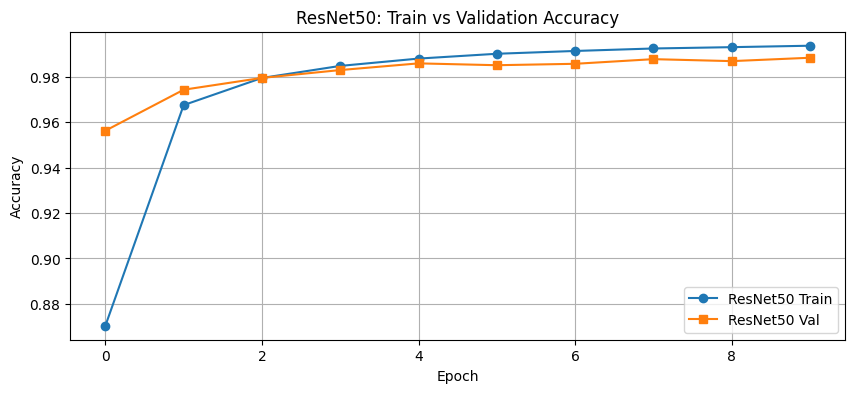

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='ResNet50 Train', marker='o')
plt.plot(val_accs, label='ResNet50 Val', marker='s')
plt.title('ResNet50: Train vs Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()


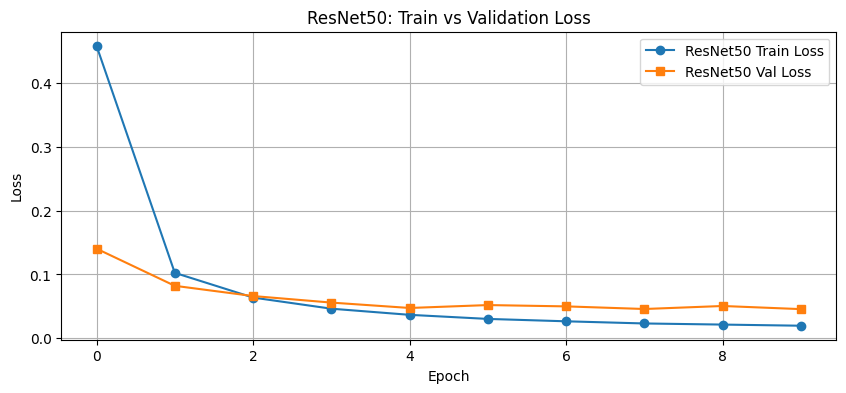

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='ResNet50 Train Loss', marker='o')
plt.plot(val_losses, label='ResNet50 Val Loss', marker='s')
plt.title('ResNet50: Train vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()


In [14]:
device = next(model.parameters()).device
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(f"ResNet50 CM shape: {cm.shape}")


ResNet50 CM shape: (123, 123)


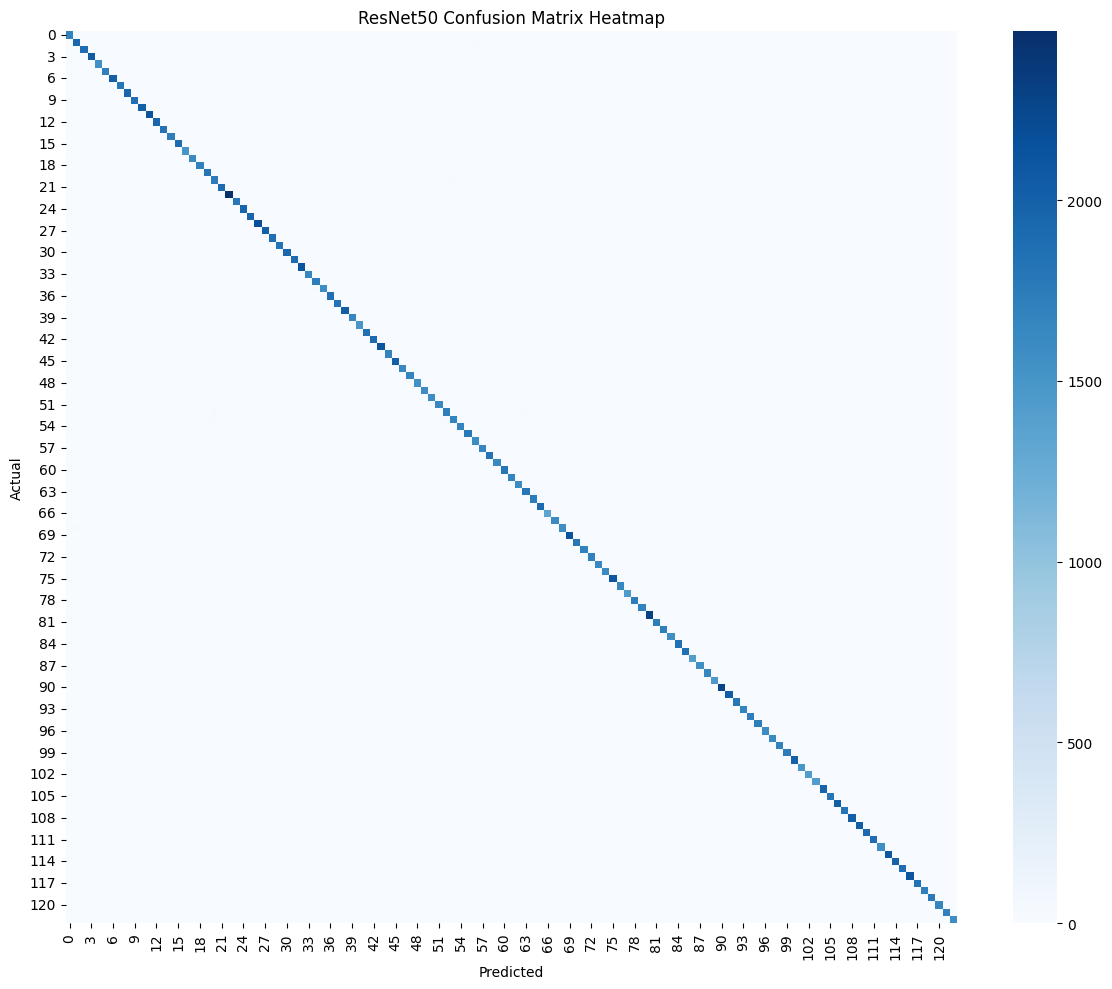

ResNet50 Classes (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [15]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('ResNet50 Confusion Matrix Heatmap')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("ResNet50 Classes (first 10):", val_dataset.classes[:10])


Loading Simple 2D CNN from disk...
Calculating predictions for Simple 2D CNN...


C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\2416233341.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model = torch.load(model_path)


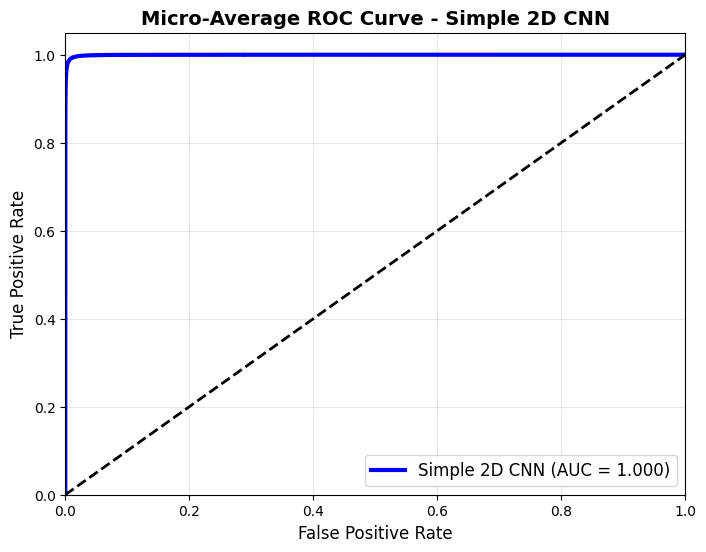

Loading Xception from disk...
Calculating predictions for Xception...


C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\2416233341.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model = torch.load(model_path)


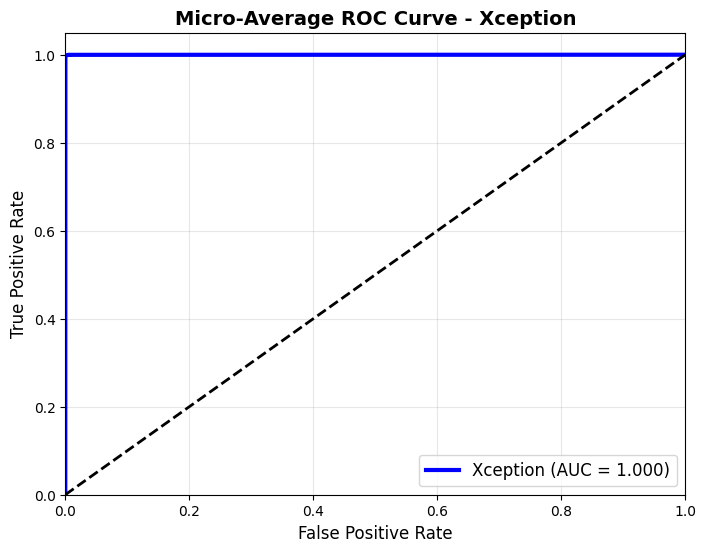

Loading ResNet50 from disk...
Calculating predictions for ResNet50...


C:\Users\swaya\AppData\Local\Temp\ipykernel_29964\2416233341.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eval_model = torch.load(model_path)


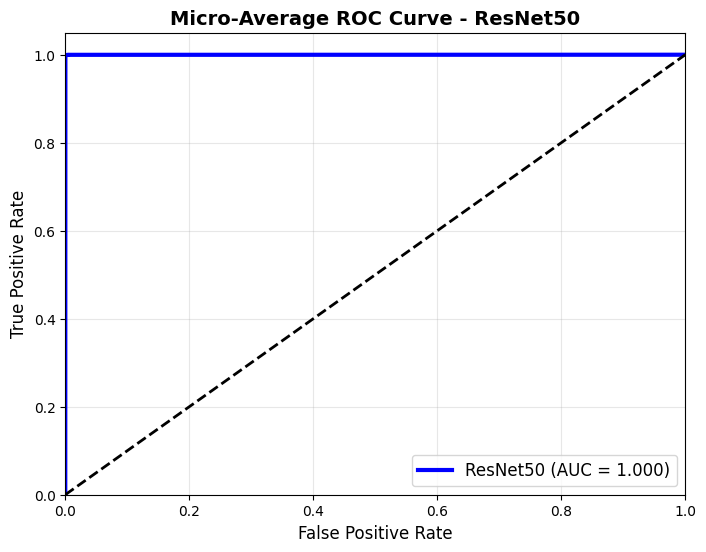

In [16]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import scipy.sparse as sp

# 1. Recreate the validation dataloader using the val_dataset you already have in memory
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Define the reusable function to load a .pth model and plot ROC
def plot_roc_from_saved_model(model_path, model_name, num_classes=123):
    print(f"Loading {model_name} from disk...")
    
    # Load the entire model from the .pth file
    eval_model = torch.load(model_path)
    eval_model = eval_model.to(device)
    eval_model.eval()

    y_true = []
    y_scores = []

    # Get predictions
    print(f"Calculating predictions for {model_name}...")
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = eval_model(inputs)
            probs = F.softmax(outputs, dim=1) 
            
            y_scores.append(probs.cpu().numpy())
            y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_scores = np.concatenate(y_scores)

    # Binarize labels for multiclass Micro-Average calculation
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # If label_binarize returned a sparse matrix (scipy.spmatrix), convert to dense numpy array
    if sp.issparse(y_true_bin):
        y_true_bin = y_true_bin.toarray()
    y_true_bin = np.asarray(y_true_bin)
    y_scores = np.asarray(y_scores)

    # Now safe to call ravel() on numpy arrays
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_micro, tpr_micro, label=f'{model_name} (AUC = {roc_auc_micro:0.3f})', color='blue', linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Micro-Average ROC Curve - {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# 3. --- PLOT SIMPLE CNN ---
plot_roc_from_saved_model('gait_simple_cnn_entire_model.pth', 'Simple 2D CNN', num_classes=len(val_dataset.classes))

# 4. --- PLOT XCEPTION ---
plot_roc_from_saved_model('gait_xception_model_overall123_subjects.pth', 'Xception', num_classes=len(val_dataset.classes))

# 5. --- PLOT RESNET50 ---
plot_roc_from_saved_model('gait_ResNet50_entire_model.pth', 'ResNet50', num_classes=len(val_dataset.classes))